# EDA for Overall Wells, Sicks, Labs, and Vaccines over (1/1/2020-3/31/2022)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
sns.set()

## Raw Data

In [59]:
df_raw = pd.read_excel("Overall_Raw_Adj.xls")

In [60]:
df_raw

,Insurance,Patient_Id,Date,Procedure,Units,Charge_Resp,Charge,Contractual_Adj,Charge Balance
0,Absolute Total Care Medicaid,72181,1/2/2020,90460,1,P,22.0,-1.84,0.0
1,Absolute Total Care Medicaid,72181,1/2/2020,90461,2,P,40.0,-16.24,0.0
2,Absolute Total Care Medicaid,72181,1/2/2020,99391,1,P,125.0,-28.41,0.0
3,Absolute Total Care Medicaid,72508,1/8/2020,99381,1,P,151.0,-43.87,0.0
4,Absolute Total Care Medicaid,72307,1/10/2020,90460,1,P,22.0,-1.84,0.0
...,...,...,...,...,...,...,...,...,...
36516,Valenz Tucker McClancy,69779,10/18/2021,90471,1,P,25.0,0.00,0.0
36517,Valenz Tucker McClancy,69779,10/18/2021,90686,1,P,30.0,0.00,0.0
36518,Valenz Tucker McClancy,69779,10/18/2021,99393,1,P,160.0,0.00,0.0
36519,WellCare Health Medicaid,72640,4/20/2020,99381,1,P,151.0,-67.95,0.0


#### List of Insurance Abbreviations, as well as CPT Codes of Visit Categories: Well, Sick, Vaccine, and Lab

In [104]:
abbs = ['ATCM', 'A', 'AS', 'AvC', 'ABS', 'Am', 'BCPPO', 'BCFEP', 'BCNC', 'BCSC', 'BPA', 'BCCP', 'CHAMP', 'C', 'CPPO', 'CAS',
        'Co', 'CoC', 'CBS', 'CBSI', 'DDP', 'EH', 'FCM', 'FLI', 'FBG', 'GEHA', 'GR', 'HP', 'HBM', 'H', 'HHH', 'IBA', 'KBA',
        'LH', 'L', 'MJIB', 'M', 'MS', 'MSC', 'MHA', 'MHM', 'NGAH', 'NoIns', 'OHP', 'PAI', 'PHCS', 'PALI', 'RC', 'RNI', 'SH',
        'TSR', 'TH', 'TSB', 'UHSM', 'UMR', 'ULI', 'UH', 'UMR', 'VTM', 'WHM']
well_CPTs = ['92551', '92552', '92552', '92552NC', '92552PP', '96110', '96110NC', '99381', '99381PP', '99382', '99383',
             '99384', '99385', '99391', '99391PP', '99392', '99392PP', '99393', '99393PP', '99394', '99394PP', '99395',
             '99406', 'G9153']
sick_CPTs = ['10060', '10120', '11981', '11982', '16020', '17250', '28190', '51701', '69090', '69200', '69209', '69210',
             '94640', '94640PP', '94664', '94664NC', '94760', '94760PP', '96161', '96372', '99202', '99203', '99203PP',
             '99204', '99205', '99211', '99211NC', '99211PP', '99212', '99212NC', '99212PP', '99213', '99213NC', '99213PP', 
             '99214', '99214PP', '99215', '99417', '99420', '99441', '99442', 'A7003', 'A7003NC', 'J0696', 'J1100', 'J7506',
             'J7510', 'J7611', 'J7619', 'J7620']
vac_CPTs = ['90460', '90460PP', '90461', '90461PP', '90471', '90472', '90473', '90474', '90474PP', '90633', '90633NC',
            '90647', '90647NC', '90651', '90651NC', '90670', '90670NC', '90680', '90680NC', '90686', '90686NC', '90686VP',
            '90696', '90696NC', '90700', '90700NC', '90707', '90707NC', '90713', '90715', '90715NC', '90716', '90716NC',
            '90723', '90723NC', '9073', '90734NC', '90744']
lab_CPTs = ['81002', '81002PP', '81025', '83655', '85025', '87804', '87804PP', '87880', '87880NC', '87880PP']

#### Remove Insurances where Units < 12 (Units indicates number of charges billed to Insurance)

In [115]:
df = df_raw.groupby('Insurance').filter(lambda x: len(x)>12)

## Aggregated Analysis

In [80]:
# Create an aggregated total of charges, contractual adjustments, and visit counts by insurance
price_df = df[['Charge','Contractual_Adj', 'Insurance']].groupby("Insurance").sum()
price_df['Counts'] = df.value_counts().groupby("Insurance").sum()
price_df['Percent_Lost'] = -100*(price_df['Contractual_Adj'] / price_df['Charge'])
# remove specific insurance with unit > 12 but total charges negligible
price_df = price_df[price_df.index!='Disability Determination Payor']
price_df['Ins_abbs'] = ['ATCM', 'A', 'AS', 'AvC', 'ABS', 'Am', 'BCPPO', 'BCFEP', 'BCNC', 'BCSC', 'BCCP', 'C', 'CPPO',
                        'CBSI', 'EH', 'FCM', 'GEHA', 'GR', 'HBM', 'H', 'KBA', 'LH', 'M', 'MS', 'MSC', 'MHA', 'MHM', 
                        'NGAH', 'NoIns', 'PHCS', 'TSR', 'TH', 'TSB', 'UMR', 'UH']



In [81]:
price_df

,Charge,Contractual_Adj,Counts,Percent_Lost,Ins_abbs
Insurance,,,,,
Absolute Total Care Medicaid,86216.50,-30379.24,923,35.235993,ATCM
Aetna,83980.50,-36649.14,840,43.640059,A
All Savers,3081.00,-900.90,26,29.240506,AS
Allegiance via Cigna,4801.50,-2231.16,49,46.467979,AvC
Allied Benefit Systems,1929.00,-804.16,15,41.687921,ABS
Ambetter,3900.50,-1175.17,38,30.128701,Am
BCBS - PPO Plans,975451.81,-334571.88,9772,34.299171,BCPPO
BCBS Federal Employee Program,24220.00,-8667.57,227,35.786829,BCFEP
BCBS NC SHP,4558.00,-1370.61,45,30.070426,BCNC


### Visits by Insurance

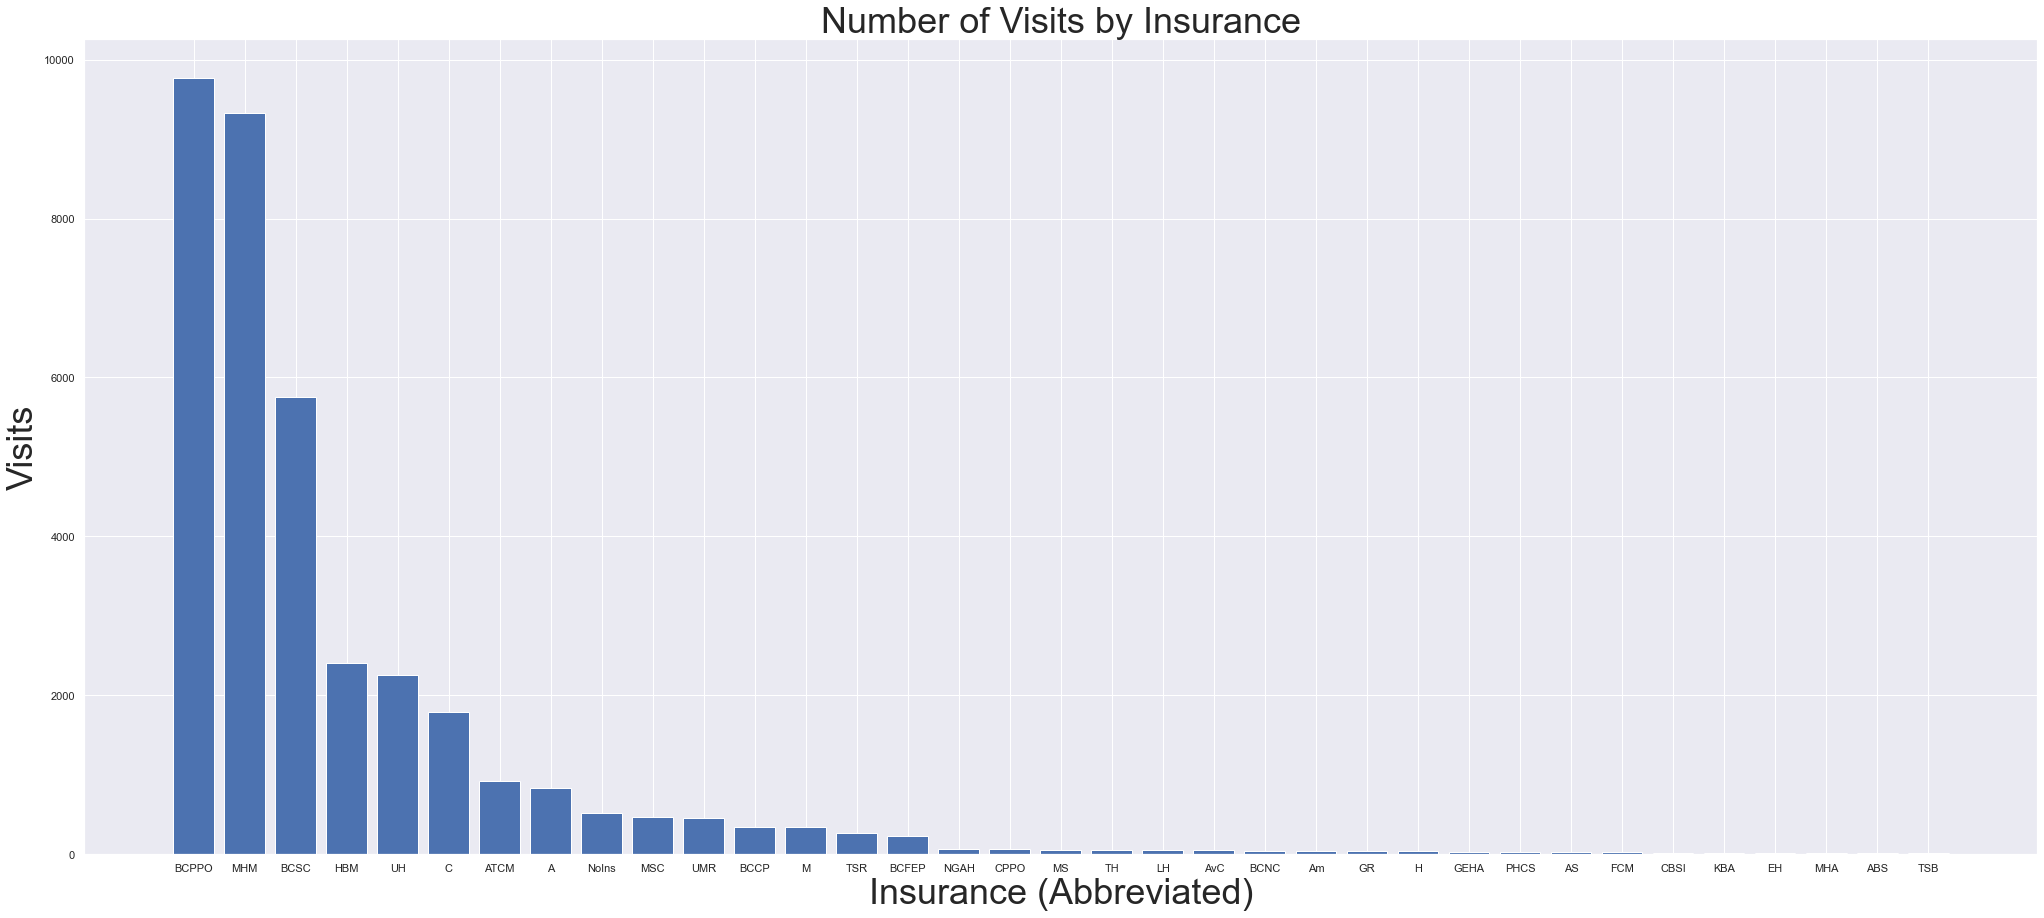

In [86]:
Insurance_abbs = price_df.sort_values(by=['Counts'], ascending=False)['Ins_abbs']
Counts = price_df.sort_values(by=['Counts'], ascending=False)['Counts']
fig = plt.figure(figsize=(35,15))
plt.xlabel("Insurance (Abbreviated)", fontsize=36)
plt.ylabel("Visits", fontsize=36)
plt.title("Number of Visits by Insurance", fontsize=36)
bar = plt.bar(Insurance_abbs, Counts)

### Percent Revenue Adjusted per Insurance

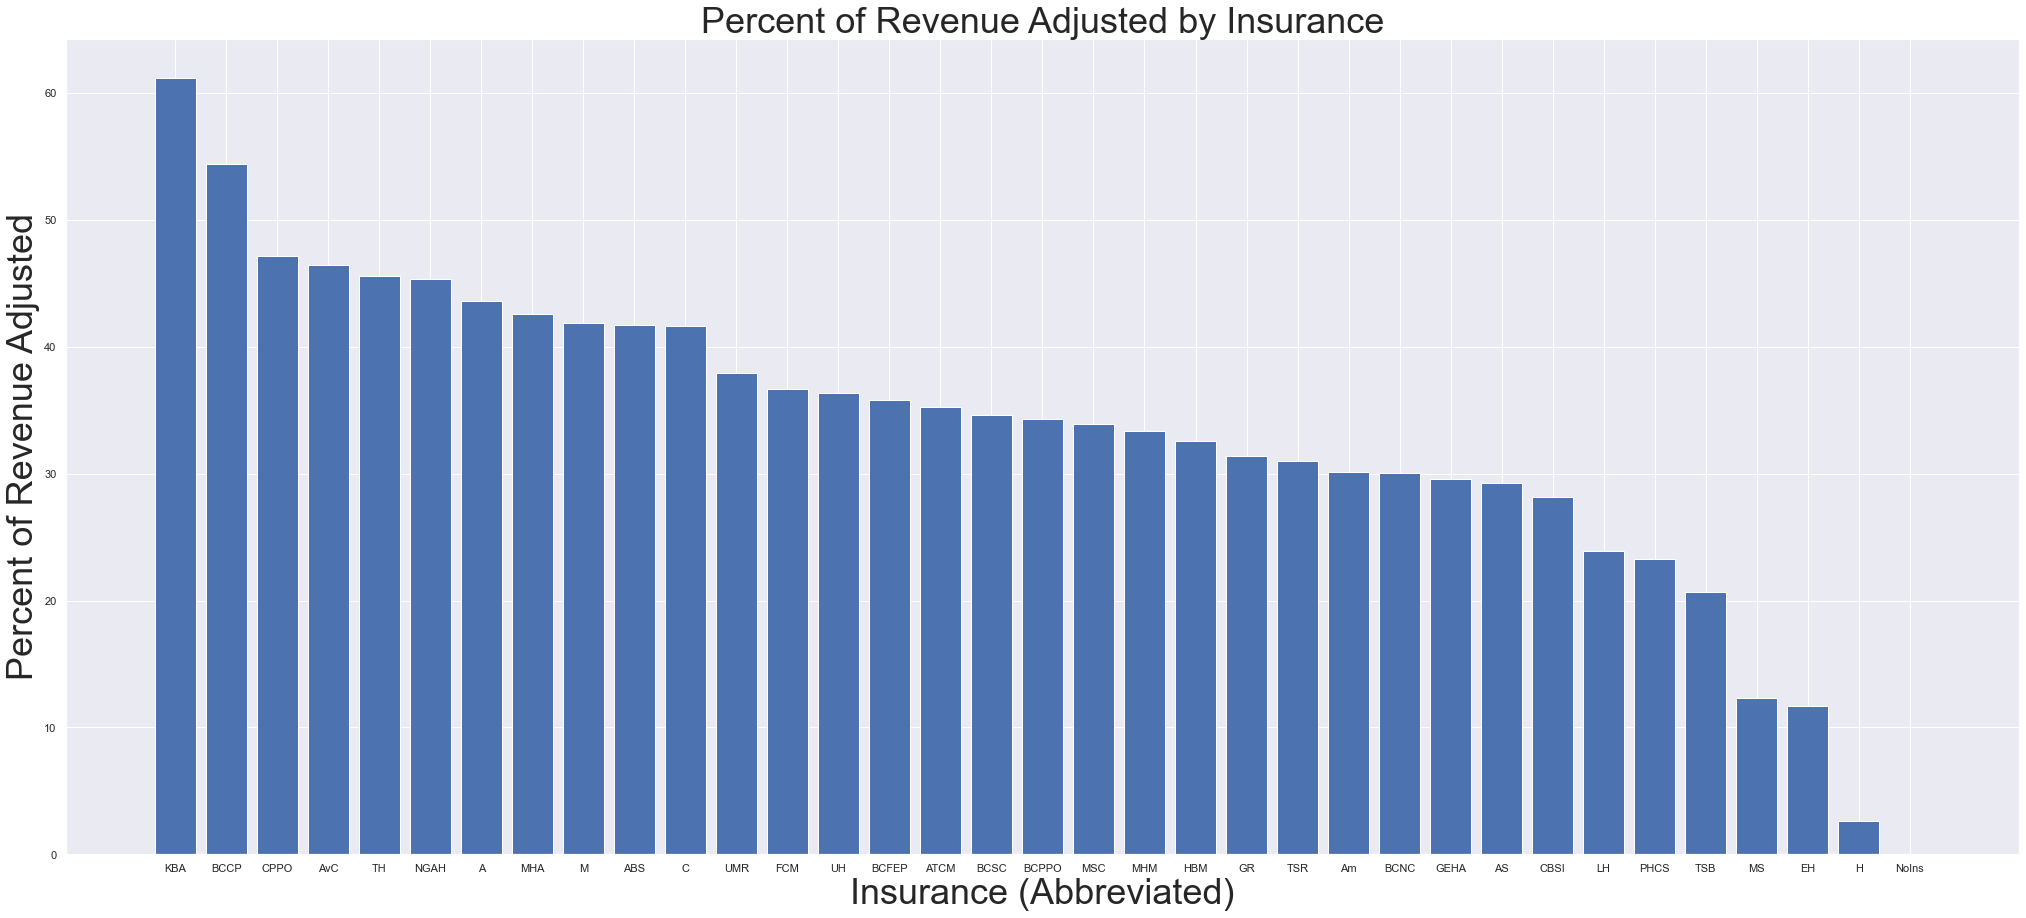

In [89]:
Insurance_abbs = price_df.sort_values(by=['Percent_Lost'], ascending=False)['Ins_abbs']
Perc = price_df.sort_values(by=['Percent_Lost'], ascending=False)['Percent_Lost']
fig = plt.figure(figsize=(35,15))
plt.xlabel("Insurance (Abbreviated)", fontsize=36)
plt.ylabel("Percent of Revenue Adjusted", fontsize=36)
plt.title("Percent of Revenue Adjusted by Insurance", fontsize=36)
bar = plt.bar(Insurance_abbs, Perc)

### Total Revenue Adjusted per Insurance

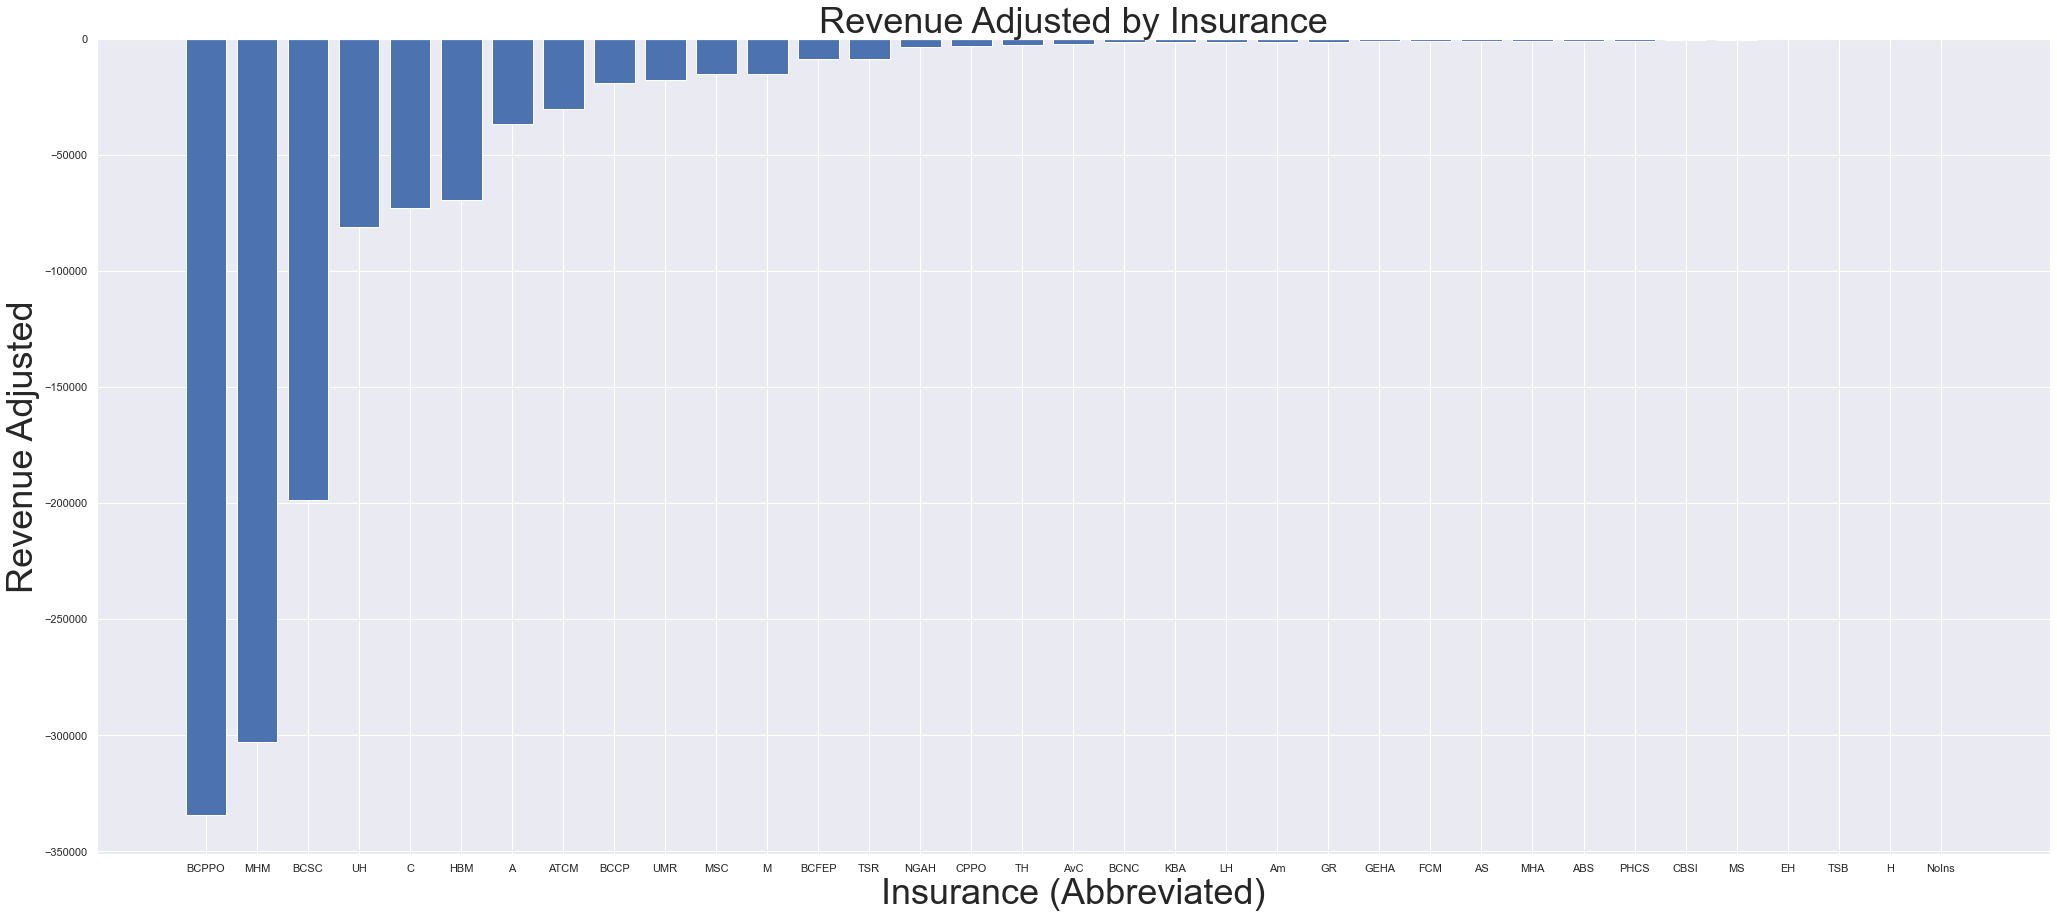

In [90]:
Insurance_abbs = price_df.sort_values(by=['Contractual_Adj'], ascending=True)['Ins_abbs']
Counts = price_df.sort_values(by=['Contractual_Adj'], ascending=True)['Contractual_Adj']
fig = plt.figure(figsize=(35,15))
plt.xlabel("Insurance (Abbreviated)", fontsize=36)
plt.ylabel("Revenue Adjusted", fontsize=36)
plt.title("Revenue Adjusted by Insurance", fontsize=36)
bar = plt.bar(Insurance_abbs, Counts)

## Analysis by Date

In [91]:
# convert date columns to usable datetime objects
df['Date'] = pd.to_datetime(df['Date'])

In [94]:
data = df.groupby('Insurance').filter(lambda x: len(x)>50)
data.value_counts().groupby('Insurance').sum()

Insurance
Absolute Total Care Medicaid      923
Aetna                             840
BCBS - PPO Plans                 9772
BCBS Federal Employee Program     227
BCBS SC SHP                      5749
BlueChoice Commercial Plan        345
Cigna                            1785
Cigna PPO via Healthgram           64
Healthy Blue Medicaid            2410
Medcost                           341
Medi-Share                         59
Medicaid of SC                    470
Molina Healthcare Medicaid       9327
National Gen Accident-Health       69
No Primary Insurance Plan         521
Tricare SOUTH Region              267
Trustmark Health                   55
UMR                               459
United Healthcare                2252
dtype: int64

<AxesSubplot:title={'center':'Weekly Visits by 19 Largest Insurances'}, xlabel='Date', ylabel='Visit Count'>

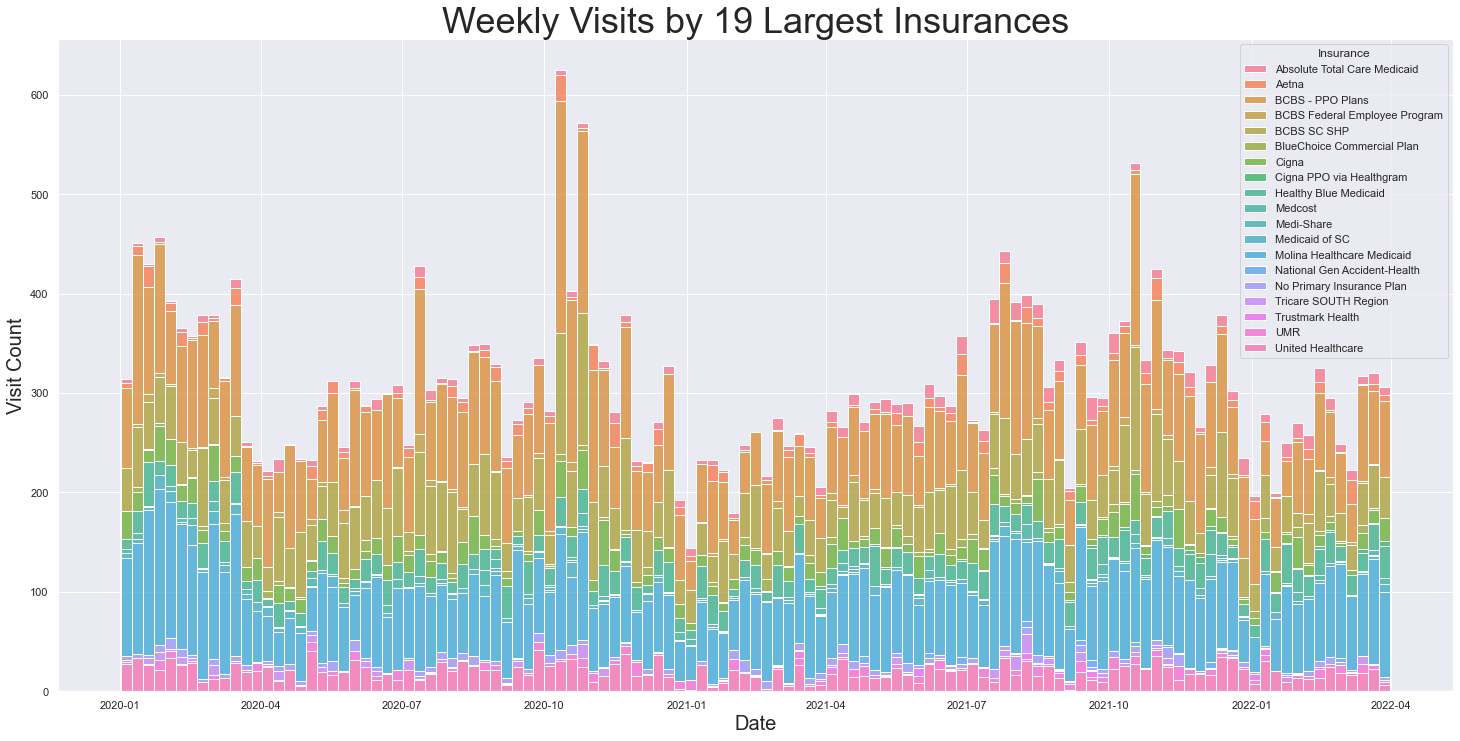

In [97]:
fig = plt.figure(figsize=(25,12))
plt.title("Weekly Visits by 19 Largest Insurances", fontsize=36)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Visit Count", fontsize=20)
custom_palette = sns.color_palette("Paired", 19)
sns.histplot(x=data['Date'], hue=data['Insurance'], stat='count',
             bins=117, multiple='stack')

## Visit Count Analysis by Patient

In [98]:
pt_data = df.groupby(['Patient_Id','Insurance']).sum()
pt_data['CPT_Counts'] = df.value_counts().groupby('Patient_Id').sum()
pt_data = pt_data.sort_values(by=['Charge'], ascending=False)

In [99]:
pt_data

,,Units,Charge,Contractual_Adj,Charge Balance,CPT_Counts
Patient_Id,Insurance,,,,,
71246,Molina Healthcare Medicaid,28,64697.48,0.00,0.0,NaN
72994,BCBS - PPO Plans,77,6937.00,-2571.88,0.0,NaN
72537,BCBS SC SHP,73,6727.00,-2384.70,0.0,NaN
72767,BCBS - PPO Plans,67,6688.00,-2428.89,0.0,NaN
72864,United Healthcare,66,6534.00,-2414.64,0.0,NaN
...,...,...,...,...,...,...
69645,No Primary Insurance Plan,1,5.00,0.00,0.0,NaN
71181,No Primary Insurance Plan,1,5.00,0.00,0.0,NaN
64907,No Primary Insurance Plan,1,5.00,0.00,0.0,NaN


In [102]:
pt_data.describe()

,Units,Charge,Contractual_Adj,Charge Balance,CPT_Counts
count,4215.000000,4215.000000,4215.000000,4215.000000,0.0
mean,9.435350,846.488368,-293.109817,8.419416,NaN
std,10.588746,1357.262790,340.165743,49.011432,NaN
min,1.000000,4.000000,-2690.290000,-30.000000,NaN
25%,3.000000,268.500000,-354.085000,0.000000,NaN
50%,6.000000,536.000000,-191.220000,0.000000,NaN
75%,11.000000,994.000000,-85.130000,0.000000,NaN
max,77.000000,64697.480000,0.000000,894.000000,NaN
